In [2]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2022-04-03 09:10:08.535896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 09:10:08.535976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0
The following GPU devices are available: 


2022-04-03 09:10:14.822761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-03 09:10:14.846351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-03 09:10:14.846382: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-03 09:10:14.846410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist


In [3]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [7]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [9]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
import matplotlib.pyplot as plt

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize([img], (640, 640))
    img = tf.cast(img, dtype = tf.float32)
    img = img/255
    return img

(1, 640, 640, 3)


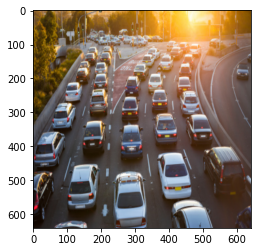

In [11]:
image = load_img('traff.jpg')
print(image.shape)
plt.imshow(image.numpy()[0,:,:,:])

In [59]:
print(image)

tf.Tensor(
[[[[189.        171.        149.       ]
   [185.5586    164.11719   135.92265  ]
   [176.79297   149.46875   115.10547  ]
   ...
   [108.         67.          5.       ]
   [107.376526   66.68826     5.       ]
   [106.         66.          5.       ]]

  [[176.14375   152.5922    124.16406  ]
   [179.13777   152.1448    119.73433  ]
   [173.98865   142.09558   105.07979  ]
   ...
   [109.16875    67.29219     4.415625 ]
   [108.72745    67.07153     4.415625 ]
   [107.75313    66.58437     4.415625 ]]

  [[152.90625   119.32031    79.27344  ]
   [167.53223   130.50488    90.47414  ]
   [168.91989   128.76868    86.958496 ]
   ...
   [111.28125    67.82031     3.359375 ]
   [111.16922    67.7643      3.359375 ]
   [110.921875   67.640625    3.359375 ]]

  ...

  [[ 22.179688   11.1796875   5.1796875]
   [ 22.86797    11.867969    5.8679686]
   [ 23.179688   12.1796875   6.1796875]
   ...
   [ 41.729675   29.249207   44.984375 ]
   [ 43.271133   31.58287    43.465103 ]
   [ 

In [12]:
def run_detector(detector, path):
  img = load_img(path)

  #converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  return result
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [13]:
def detect_img(image_path):
  start_time = time.time()
  res = run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)
  return (res, end_time)

In [29]:
img1 = detect_img('traff10.jpg')

Inference time: 9.046445846557617


In [ ]:
img1[0].get("detection_class_entities")

In [44]:
entities = []
car_names = ['Car', 'Taxi', 'Land vehicle', 'Van', 'Truck', 'Vehicle', 'Bus', 'Motorcycle', 'Ambulance']
car_dict = {'Car': 0, 'Taxi': 0, 'Land vehicle': 0, 'Van': 0, 'Truck': 0, 'Vehicle': 0, 'Bus': 0, 'Motorcycle': 0, 'Ambulance': 0}
for i in img1[0].get("detection_class_entities"):
    entities.append(i.decode("utf-8"))
for j in entities:
    if j in car_names:
        car_dict[j] += 1
car_dict

{'Car': 10,
 'Taxi': 11,
 'Land vehicle': 9,
 'Van': 2,
 'Truck': 2,
 'Vehicle': 5,
 'Bus': 2,
 'Motorcycle': 0,
 'Ambulance': 0}

In [30]:
print(img1)

({'detection_class_entities': array([b'Taxi', b'Taxi', b'Taxi', b'Taxi', b'Car', b'Taxi',
       b'Vehicle registration plate', b'Tree', b'Wheel', b'Wheel',
       b'Wheel', b'Building', b'Wheel', b'Person', b'Tree', b'Wheel',
       b'Wheel', b'Taxi', b'Wheel', b'Car', b'Van', b'Building', b'Car',
       b'Building', b'Wheel', b'Tree', b'Taxi', b'Tire', b'Car', b'Tree',
       b'Person', b'Wheel', b'Car', b'Land vehicle', b'Wheel',
       b'Land vehicle', b'Tire', b'Tree', b'Window', b'Wheel', b'Car',
       b'Van', b'Wheel', b'Vehicle', b'Land vehicle', b'Tire',
       b'Land vehicle', b'Land vehicle', b'Wheel', b'Tree', b'Wheel',
       b'Clothing', b'Car', b'Land vehicle', b'Tire', b'Clothing',
       b'Vehicle', b'Truck', b'Wheel', b'Bus', b'Wheel', b'Woman',
       b'Land vehicle', b'Tree', b'Tree', b'Tire', b'Taxi', b'Taxi',
       b'Wheel', b'Person', b'Tire', b'Wheel', b'Person', b'Building',
       b'Wheel', b'Man', b'Wheel', b'Car', b'Tire', b'Car', b'Tire',
       b'Tree', 

In [ ]:
# collect car names from diff pics
# 0.7 0.5 0.2 for every threshold run
# zip anem, mecery vercnem
# mi function sarqel

In [1]:
car_names = ['Car', 'Taxi', 'Land vehicle', 'Van', 'Truck', 'Vehicle', 'Bus', 'Motorcycle', 'Ambulance']